In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
from numpy.linalg import norm, inv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import hdbscan
import cv2
import os
from operator import itemgetter
from visualization_dimensionality_red_functions import *
from clustering_functions import *
from skeletons_aux_functions import *
from augmentation_script import *

# Load files

Load features

In [2]:
vggfeatures = scipy.io.loadmat('girosmallveryslow2_vggfeatures.mat')['features']
clipfeatures = scipy.io.loadmat('girosmallveryslow2_clipfeatures.mat')['features']
features = np.concatenate((vggfeatures, clipfeatures), axis=0)

Load skeletons

In [3]:
data = np.load('skeleton_reconstructed.npy')
# get the frames
frames = data[0, :]
# get the skeletons
skeletons = np.delete(data, 0, axis=0)

data = pd.DataFrame(data.T)
data.rename(columns={0: 'frames'}, inplace=True)

Load outliers

In [4]:
outliers = np.load('outliers.npy')

Load images

In [5]:
folder = 'images_giroslow'
images_path = sorted(os.listdir(folder), key=lambda x: os.path.getmtime(os.path.join(folder, x)))

# Augmented data

Get angles in joints

In [6]:
angles_matrix = joints_angles_matrix(skeletons, frames)

d:\IST\MEEC\4º Ano\P4\PBD\Projeto\skeletons_aux_functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
d:\IST\MEEC\4º Ano\P4\PBD\Projeto\skeletons_aux_functions.py:18: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


Get descriptors

In [7]:
skeletons_descriptors = get_skel_descriptors(angles_matrix, data, frames, outliers)

Get augmented data 

In [8]:
augmented_data = get_augmented_data(features, skeletons_descriptors).values.T
frames = augmented_data[0, :].astype(int)
augmented_data = np.delete(augmented_data, 0, axis=0)

# delete the outliers
augmented_data = np.delete(augmented_data, outliers, axis=1)
frames = np.delete(frames, outliers, axis=0)

# Center data 

In [9]:
augmented_data_cnt, scaler = data_centering(augmented_data, with_std=True)

# Rank and dimensionality reduction

Get rank

In [ ]:
svd = data_visualization(augmented_data_cnt, method='svd', n_components=augmented_data_cnt.shape[0])

# Calculate the rank of the features
cum_var = np.cumsum(svd.explained_variance_ratio_)
rank = np.where(cum_var > 0.9)[0][0] + 1
print('Rank:', rank)

Visualize dimensionality reduction with PCA

In [103]:
embedding_PCA = data_visualization(augmented_data, method='pca', n_components=3)

Visualize dimensionality reduction with TSNE

In [275]:
embedding_TSNE = data_visualization(augmented_data, method='tsne', n_components=3, n_neighbors=12)

c:\Users\duart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Visualize dimensionality reduction with UMAP

In [10]:
embedding_UMAP = data_visualization(augmented_data_cnt, method='umap', n_components=3, n_neighbors=12)

# Similarity matrix

Get similarity matrix

In [11]:
similarity_type = 4 # 1 for cosine and unreduced data, 2 for euclidean and unreduced data, 3 for cosine and reduced data, 4 for euclidean and reduced data

if similarity_type == 1:
    similarity_matrix = get_similarity_matrix(augmented_data, similarity='cosine')
elif similarity_type == 2:
    similarity_matrix = get_similarity_matrix(augmented_data, similarity='euclidean')
elif similarity_type == 3:
    similarity_matrix = get_similarity_matrix(embedding_UMAP, similarity='cosine')
elif similarity_type == 4:
    similarity_matrix = get_similarity_matrix(embedding_UMAP, similarity='euclidean')
    # similarity_matrix = get_similarity_matrix(embedding_TSNE, similarity='euclidean')


Similarity matrix histogram

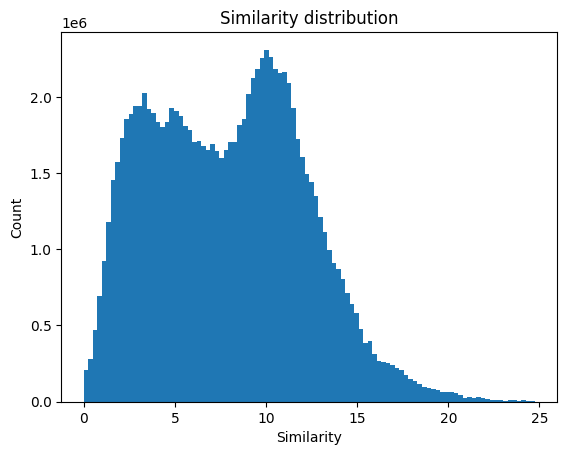

In [12]:
similarity_matrix_hist(similarity_matrix)

Get epsilon for DBSCAN

In [13]:
eps = float(np.quantile(similarity_matrix, 0.002))
print('Eps:', eps)

Eps: 0.24237313866615295


# DBSCAN Clustering

In [14]:
dbscan_clusterer = clusterer_function(method='DBSCAN', similarity_matrix=similarity_matrix, precomputed=True, min_samples=3, eps=eps)

Clusters sizes histogram

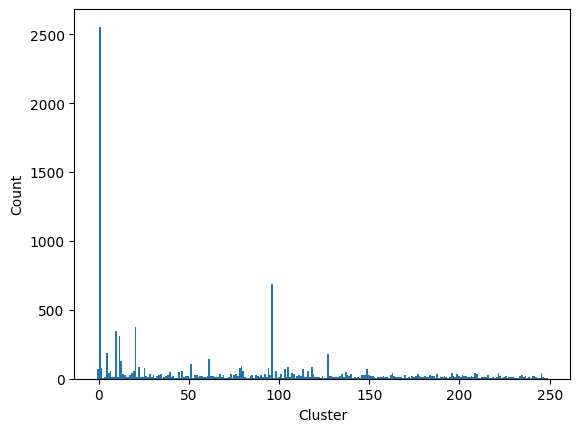

Number of clusters: 251
Highest number of elements in a clusters: 2555
Smallest number of elements in a clusters: 3


In [15]:
cluster_size_hist(dbscan_clusterer)

Unlabeled frames 

In [283]:
unlabeled = np.where(dbscan_clusterer.labels_ == -1)[0]
print('Number of unlabeled frames:', len(unlabeled))

Number of unlabeled frames: 456


Unlabeled frames visualization

In [255]:
visualization_w_images( cluster=frames[unlabeled], folder= folder, images_path=images_path)

Create cluster dictionary

In [18]:
dbscan_cluster_dict = {}
for i in np.unique(dbscan_clusterer.labels_):
    if i != -1: # ignore unlabled frames
        dbscan_cluster_dict[i] = np.where(dbscan_clusterer.labels_ == i)[0]

Visualization of some random clusters

In [257]:
clusters = np.random.choice(list(dbscan_cluster_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[dbscan_cluster_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

Get bases for clusters and Compute NSI matrix

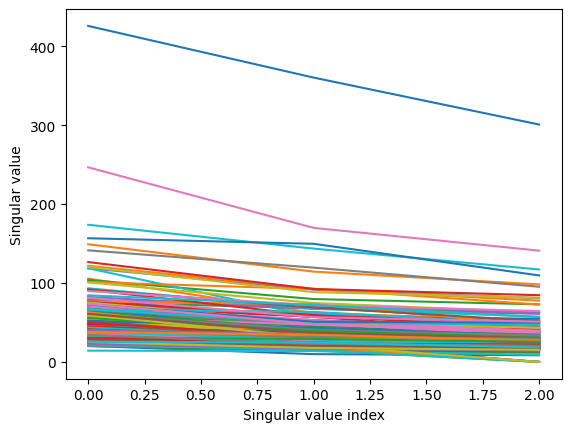

Text(0.5, 0, 'NSI')

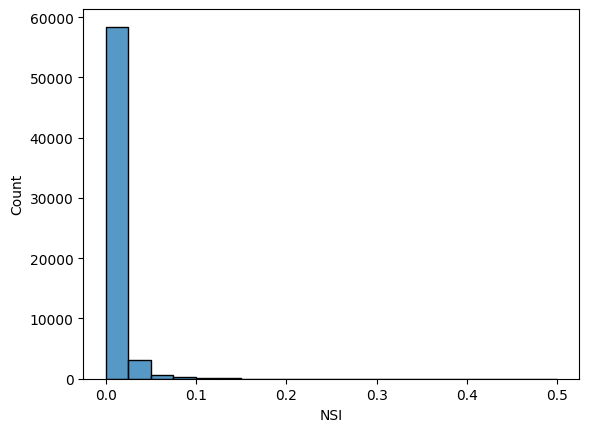

In [20]:
bases, sv = get_bases(dbscan_cluster_dict, augmented_data_cnt)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(dbscan_cluster_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)
plt.xlabel('NSI')

Visualize sparse NSI matrix

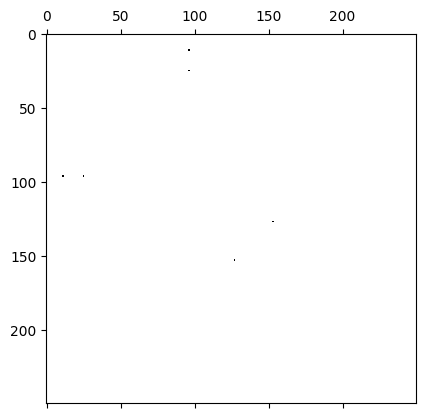

In [21]:
threshold = 0.3
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [ ]:
dbscan_cluster_dict, NSI_matrix = final_cluster_merger(dbscan_cluster_dict, augmented_data_cnt, NSI_matrix, threshold)

Visualize random cluster

In [ ]:
clusters = np.random.choice(list(dbscan_cluster_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[dbscan_cluster_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

# Clustering by cosine similarity

Cosine similarity plot between 1000 consecutive frames with skeletons

In [ ]:
cluster_cos_dict, outliers_2 = clustering_by_cos_sim(augmented_data_cnt.T, threshold=0.35)
plt.show()
print('Number of outliers: ', len(outliers_2))

Visualize some random clusters and second set of outliers

In [ ]:
visualization_w_images(cluster = frames[outliers_2], folder= folder, images_path=images_path)
clusters = np.random.choice(list(cluster_cos_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[cluster_cos_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

Get bases for clusters and Compute NSI matrix

In [ ]:
bases, sv = get_bases(cluster_cos_dict, augmented_data_cnt)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(cluster_cos_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)
plt.xlabel('NSI')

Visualize sparse NSI matrix

In [ ]:
threshold = 0.35
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [ ]:
cluster_cos_dict, NSI_matrix = final_cluster_merger(cluster_cos_dict, augmented_data_cnt, NSI_matrix, threshold)

Visualize random cluster

In [ ]:
visualization_w_images(cluster = frames[cluster_cos_dict[np.random.choice(list(cluster_cos_dict.keys()))]], folder= folder, images_path=images_path)

# KMeans clustering

In [25]:
KMeans_clusterer = clusterer_function(method='KMeans',data=augmented_data_cnt, n_clusters=10)

Clusters sizes histogram

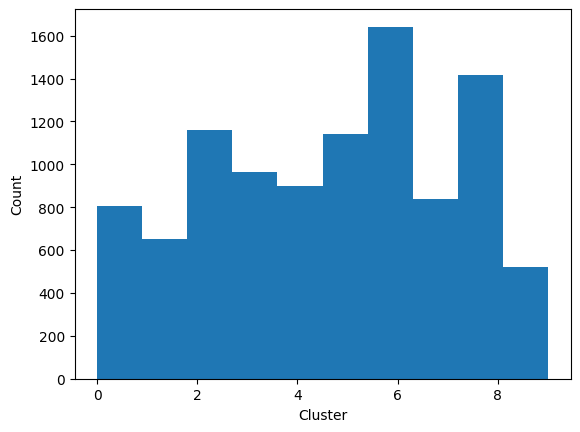

Number of clusters: 10
Highest number of elements in a clusters: 1642
Smallest number of elements in a clusters: 0


In [26]:
cluster_size_hist(KMeans_clusterer)

Create cluster dictionary

In [27]:
KMeans_cluster_dict = {}
for i in np.unique(KMeans_clusterer.labels_):
        KMeans_cluster_dict[i] = np.where(KMeans_clusterer.labels_ == i)[0]

Visualization of some random cluster

In [79]:
clusters = np.random.choice(list(KMeans_cluster_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[KMeans_cluster_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

Get bases for clusters and Compute NSI matrix

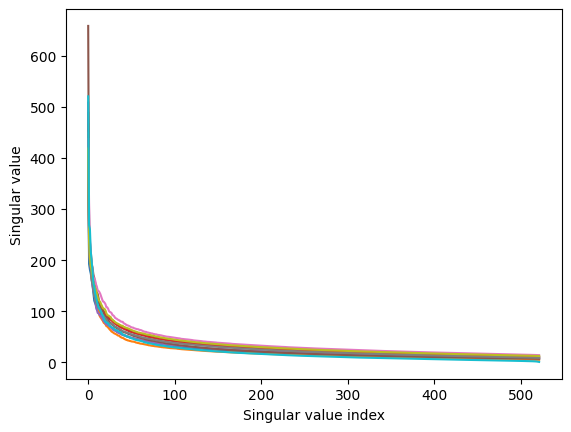

<AxesSubplot: ylabel='Count'>

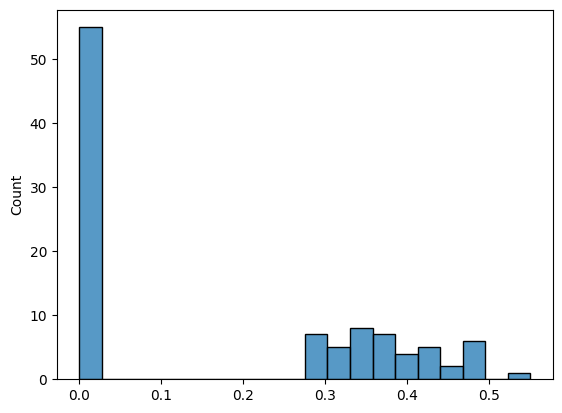

In [30]:
bases, sv = get_bases(KMeans_cluster_dict, augmented_data_cnt)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(KMeans_cluster_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)

Visualize sparse NSI matrix

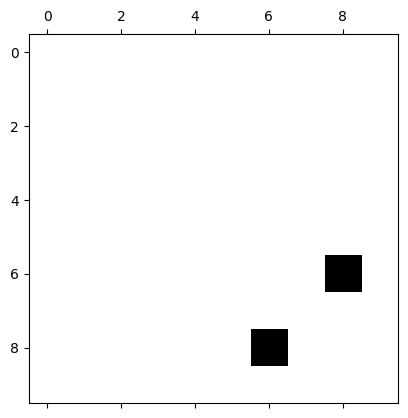

In [32]:
threshold = 0.5
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [33]:
KMeans_cluster_dict, NSI_matrix = final_cluster_merger(KMeans_cluster_dict, augmented_data_cnt, NSI_matrix, threshold)

Number of clusters:  9
Number of elements in biggest cluster:  3058


Number of clusters:  8
Number of elements in biggest cluster:  4217
Number of clusters:  7
Number of elements in biggest cluster:  5182


Visualize random cluster

In [34]:
clusters = np.random.choice(list(KMeans_cluster_dict.keys()), 7, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[KMeans_cluster_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

As it can be seen by the images KMeans clustering did a great job is clustering the data, it separated the frames by shot in different clusters and joined the frames with animations and some of the outliers that were not detected yet into two clusters. And with the auxiliary information provided by the skeleton descriptors it was possible to merge the clusters that were not correctly separated by just using the features alone.